In [82]:
from colomoto.minibn import *
import pandas as pd
import bonesis

### Load synthetic Boolean network and associated configurations

# computing graph layout...


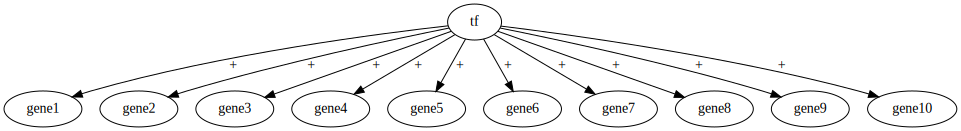

In [83]:
f = BooleanNetwork.load("boolean-network.bnet")
f_ig = f.influence_graph()
f_ig

# computing graph layout...


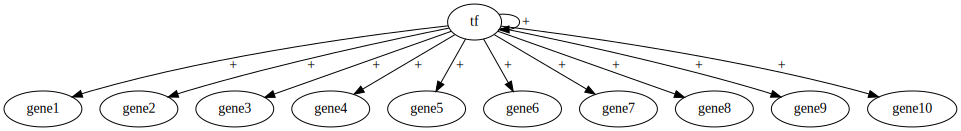

In [84]:
# Create influence graph with Bonesis format
influences = [
("tf","tf",dict(sign=1)),
("tf","gene1",dict(sign=1)),
("tf","gene2",dict(sign=1)),
("tf","gene3",dict(sign=1)),
("tf","gene4",dict(sign=1)),
("tf","gene5",dict(sign=1)),
("tf","gene6",dict(sign=1)),
("tf","gene7",dict(sign=1)),
("tf","gene8",dict(sign=1)),
("tf","gene9",dict(sign=1)),
("tf","gene10",dict(sign=1)),
]

# 
net = bonesis.InfluenceGraph(influences, exact=True)
net

In [85]:
initial_state = f.zero()
initial_state["tf"] = 1
initial_state

{'tf': 1,
 'gene1': 0,
 'gene2': 0,
 'gene3': 0,
 'gene4': 0,
 'gene5': 0,
 'gene6': 0,
 'gene7': 0,
 'gene8': 0,
 'gene9': 0,
 'gene10': 0}

In [86]:
priority = [f"gene{g}" for g in [2,8,3,4,1,9,5,10,7,6]]
assert len(set(priority)) == 10
class PriorityDynamics(UpdateModeDynamics):
    def __call__(self, x):
        y = self.model(x)   # f(x)
        for a in priority:
            if y[a] != x[a]:
                z = x.copy()
                z[a] = y[a]
                yield z
                return
        for a in self.nodes:
            if y[a] != x[a]:
                z = x.copy()
                z[a] = y[a]
                yield z

In [87]:
def node_to_dict(dyn, n):
    return {a: int(v) for (a,v) in zip(dyn.nodes, n)}

def make_labels(G):
    assert nx.is_tree(G)
    root = next(n for (n,ind) in G.in_degree() if ind == 0)
    G.nodes()[root]["label"] = "init" if G.out_degree(root) > 0 else "steady"
    ids = {"switch": 0, "steady": 0}
    def label_tree(root, begin):
        for n in G.successors(root):
            label_branch(n, begin)
    def label_branch(n, begin):
        global switch_id
        global steady_id
        if G.out_degree(root) != 1:
            assert NotImplementedError
        final_branch = len(list(nx.attracting_components(G.subgraph(nx.descendants(G, n))))) == 1
        final_key = "steady" if final_branch else "switch"
        ids[final_key] += 1
        dest = f"{final_key}{ids[final_key]}"
        i = 1
        while G.out_degree(n) == 1:
            label = f"{begin}_to_{dest}_{i}"
            G.nodes()[n]["label"] = label
            n = list(G.successors(n))[0]
            i += 1
        G.nodes()[n]["label"] = dest
        label_tree(n, dest)
    label_tree(root, "init")
    return G

def make_traj_df(f, initial_state):
    dyn = PriorityDynamics(f)
    stg = dyn.partial_dynamics(initial_state)
    make_labels(stg)
    return pd.DataFrame.from_dict({d["label"]: node_to_dict(dyn, n) for n, d in stg.nodes(data=True)}).T

In [88]:
data = make_traj_df(f, initial_state=initial_state)
data = data.to_dict(orient = 'index')

In [96]:
bo = bonesis.BoNesis(net,data)

In [97]:
bo.fixed(~bo.obs('steady1'));

In [91]:
#~bo.obs("init") >= ~bo.obs('init_to_steady1_4');

In [98]:
solutions = list(bo.boolean_networks())

Grounding...done in 0.0s


In [100]:
solutions

[gene1 <- tf
 gene10 <- tf
 gene2 <- tf
 gene3 <- tf
 gene4 <- tf
 gene5 <- tf
 gene6 <- tf
 gene7 <- tf
 gene8 <- tf
 gene9 <- tf
 tf <- tf]